### How To: Train a BPNet model using the Python API

There are two ways one can train a BPNet model using bpnet-lite: (1) using the Python API, as we will discuss here, and (2) using the command-line tools. Each approach has trade-offs, with the Python API likely being more familiar to those who are developers and easier to integrate into other code-bases, and the command-line tool being easier for those who are just looking to train a model as fast as possible. Because bpnet-lite aims to be as light-weight and low-level as possible, the Python API provides a great deal of flexibility to make changes to the standard pipeline.

Here, we will focus on a BPNet model trained to predict CTCF binding in HepG2. Specifically, this is ENCODE Accession ENCSR000BIE. Just in case it is not clear, we use a lot of ENCODE data in these tutorials because it is well organized and easy, but there is no requirement that the data be from the ENCODE Portal. All you need are bigWigs with the signals as well as peaks and negatives (which can be calculated from the peaks using `bpnet negatives`).

#### Loading the Data

The first step is to provide filenames for where your data are. Unlike the command-line tool, the Python API does not handle the preprocessing of data, so you will need to provide bigWigs with your signal as well as peak and negative files and the genome you want to use. The peaks and negatives can be either bed or bed.gz and can actually be hosted remotely if necessary.

In [1]:
seq = "/home/jmschrei/common/hg38.fa"
controls = ['ctcf-bpnet/ctcf-hepg2-control.+.bw', 'ctcf-bpnet/ctcf-hepg2-control.-.bw']
signals = ['ctcf-bpnet/ctcf-hepg2.+.bw', 'ctcf-bpnet/ctcf-hepg2.-.bw']

peaks = 'ctcf-bpnet/ENCFF199YFA.bed.gz'
negatives = 'ctcf-bpnet/ctcf-hepg2.negatives.bed'

Next, we wrap the training data in a generator that will be used to train the model. This generator starts off by loading all of the peaks and negatives into memory with padding on either side equal to the maximum jitter. This includes both the sequence, which will be input to the model, the signal, which is being predicted, and the control tracks, which are optional inputs to the model. During training, slices of these padded sequences are taken to simulate the process of jittering the sequences while still allowing pre-loaded of the sequences into memory so we do not need to load from disk. We will also specify which chromosomes to use for training: this allows us to pass the same peak and negative file into each of the data loaders and have them subsequently filter out examples not on the training chromosomes.

In [2]:
from bpnetlite.io import PeakGenerator

training_chroms = [
    "chr2", "chr4", "chr5", "chr7", "chr9", "chr10", "chr11", "chr12", 
    "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19",
    "chr21", "chr22", "chrX", "chrY"
]

training_data = PeakGenerator(
    peaks=peaks,
    negatives=negatives,
    sequences=seq,
    signals=signals,
    controls=controls,
    chroms=training_chroms,
    negative_ratio=0.33,
    random_state=0,
    batch_size=64,
    verbose=True
)

Loading Loci: 100%|████████████████████████████████████████████████████████████| 42358/42358 [00:04<00:00, 10178.07it/s]



Filtered Peaks: 197
Filtered Negatives: 0


Looks like a few examples got filtered. This happens when the extracted example falls off the side of the chromosomes, fall within the blacklist regions (not provided here, but can be provided), or have to many N characters in them.

Next, we will load up the validation data. Because we do not need padding and do not need to sample batches for training, we can use the default extract loci function. 

In [3]:
from tangermeme.io import extract_loci

validation_chroms = ['chr8', 'chr20']

X_valid, y_valid, X_ctl_valid = extract_loci(
    sequences=seq,
    signals=signals,
    in_signals=controls,
    loci=peaks,
    chroms=validation_chroms,
    max_jitter=0,
    verbose=True
)

X_valid.shape, X_ctl_valid.shape, y_valid.shape

Loading Loci: 100%|██████████████████████████████████████████████████████████████| 4780/4780 [00:00<00:00, 10051.56it/s]


(torch.Size([4780, 4, 2114]),
 torch.Size([4780, 2, 2114]),
 torch.Size([4780, 2, 1000]))

#### BPNet Model and Training

Next, we can define the BPNet model architecture parameters. There are many you can modify, including the number of filters and the number of layers, but the most important ones are the number of outputs and the number of control tracks. Because we are predicting stranded outputs here, and because we have control tracks, we will set both to 2, but they do not need to be set to the same value. A note, though, is that BPNet only predicts a single log count value regardless of the number of output tracks. This is the normal behavior when predicting chromatin accessibility or transcription factor binding, but may result in odd consequences if you start making predictions for a bunch of different tracks.

An important consideration when training BPNet models is setting `count_loss_weight`, which is a weight on the count loss. In the command-line API, this is automatically calculated for you, but it must be manually set when you use the Python API. It is calculated as the sum of the number of reads in an example, averaged across examples and strands. The pipeline uses the following code to determine it:

```python
	if parameters['count_loss_weight'] is None:
		peak_read_count = training_data.dataset.peak_signals.sum(axis=-1)
		count_loss_weight = peak_read_count.mean(axis=(0, 1)).item()
		parameters['count_loss_weight'] = count_loss_weight
```

Here, we are using the value derived from the official repository so that we can have a fair comparison later on.

In [4]:
from bpnetlite.bpnet import BPNet

model = BPNet(
    n_outputs=2,
    n_control_tracks=2,
    count_loss_weight=124.035,
    name='ctcf-bpnet/model',
    verbose=True
).cuda()

Now, we have to specify the optimizer. Vanilla Adam with a learning rate of 0.001 is the default.

In [5]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

BPNet also uses a scheduler that cuts the learning rate in half when a specified number of epochs have been reached without improving the loss. Note that this plays with the early stopping that is built into the `fit` function, which will usually terminate the training procedure before reaching the threshold and minimum learning rates set here.

In [6]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
	patience=5, threshold=0.0001, min_lr=0.0001)

Then, we can train the model using the `fit` function. Here, we pass in a few training specific hyperparameters as well as the training and validation data.

In [7]:
model.fit(
    training_data, optimizer, scheduler,
    X_valid=X_valid, 
    X_ctl_valid=X_ctl_valid, 
    y_valid=y_valid, 
    max_epochs=50,
    batch_size=128,
    early_stopping=5,
    device='cuda'
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	898	6.6875	0.3842	381.8342	0.5251	407.2075	0.41983423	0.59712267	0.4542	True
1	1796	6.1871	0.1942	350.2059	0.3744	393.9158	0.43557942	0.71063036	0.3375	True
2	2694	6.2182	0.1949	411.1587	0.3707	391.1888	0.44186798	0.7465077	0.2894	True
3	3592	6.161	0.1953	373.5336	0.3177	390.0112	0.4454455	0.76701236	0.2678	True
4	4490	6.1695	0.1964	307.6154	0.2309	388.776	0.44791612	0.7800946	0.2423	True
5	5388	6.1677	0.1968	332.8315	0.224	389.8837	0.4490773	0.78811306	0.2493	False
6	6286	6.2306	0.2099	322.2471	0.1584	387.48	0.44984755	0.7793525	0.3057	False
7	7184	6.0064	0.1968	346.826	0.3733	386.7539	0.45105067	0.7895414	0.2312	True
8	8082	5.9378	0.2005	336.1071	0.2456	386.9609	0.45094076	0.79110396	0.2436	False
9	8980	5.9679	0.218	365.19	0.3085	386.4074	0.45112094	0.7961907	0.2457	False
10	9878	6.0746	0.201	381.6792	0.2964	3

Running this function will print a log to the screen containing some important statistics about training, and save this same log to disk under <name>.log where <name> is specified when you create the BPNet object.

#### Comparison to Official BPNet

We can now compare the performance of this model to the official TensorFlow model to ensure that they are of comparable performance. First, we will load the model from the tarball uploaded to the ENCODE Portal for this experiment. See the tutorial on loading models for more details on what we are doing here.

In [8]:
import tarfile

from io import BytesIO
from bpnetlite.bpnet import BasePairNet

with tarfile.open("ctcf-bpnet/ENCFF328YVP.tar.gz", "r:gz") as tar:
    model_tar = tar.extractfile("./fold_0/model.fold_0.ENCSR000BIE.h5").read()

official_bpnet = BasePairNet.from_bpnet(
    BytesIO(model_tar)
)

official_bpnet

BasePairNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)

Now, we can make predictions for both models on the validation data, making sure to pass in the control tracks for both.

In [9]:
from tangermeme.predict import predict

new_y_logits, new_y_logcounts = predict(model, X_valid, args=(X_ctl_valid,))
official_y_logits, official_y_logcounts = predict(official_bpnet, X_valid, args=(X_ctl_valid,))

Then, we can use the built-in performance measures to fairly compare the performance of the two models.

In [10]:
from bpnetlite.performance import calculate_performance_measures

lite_perfs = calculate_performance_measures(new_y_logits, y_valid, new_y_logcounts)
off_perfs = calculate_performance_measures(official_y_logits, y_valid, official_y_logcounts)

We can start off by looking at the log count Pearson.

In [11]:
lite_perfs['count_pearson'], off_perfs['count_pearson']

(tensor([0.8116]), tensor([0.8123]))

Looks like the two are of similar performance.

Next, we can look at the profile Pearson.

In [12]:
import numpy

numpy.nan_to_num(lite_perfs['profile_pearson']).mean(), numpy.nan_to_num(off_perfs['profile_pearson']).mean()

(0.45348364, 0.4504725)

Again, it looks like they are of similar performance.

As a more visual comparison of the two, we can take a look at what the predictions from the two models are at a locus of interest.

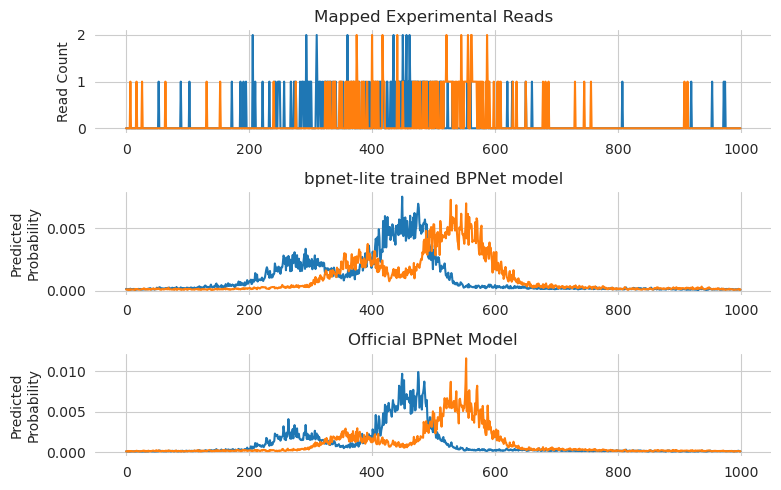

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(8, 5))
plt.subplot(311)
plt.title("Mapped Experimental Reads")
plt.plot(y_valid[1793].T)
plt.ylabel("Read Count")
seaborn.despine(bottom=True, left=True)

plt.subplot(312)
plt.title("bpnet-lite trained BPNet model")
plt.plot(torch.softmax(new_y_logits[1793], dim=-1).T)
plt.ylabel("Predicted\nProbability")
seaborn.despine(bottom=True, left=True)

plt.subplot(313)
plt.title("Official BPNet Model")
plt.ylabel("Predicted\nProbability")
plt.plot(torch.softmax(official_y_logits[1793], dim=-1).T)
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

Ut sems like the predicctions are pretty similar for both of them, with both models getting the positioning of the primary peak as well as the much weaker peak to the left.

Finally, we can look at the attributions for the models at this locus.

In [14]:
from tangermeme.deep_lift_shap import deep_lift_shap

from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

X_attr0 = deep_lift_shap(CountWrapper(ControlWrapper(model)), X_valid[1793:1794])
X_attr1 = deep_lift_shap(CountWrapper(ControlWrapper(official_bpnet)), X_valid[1793:1794])

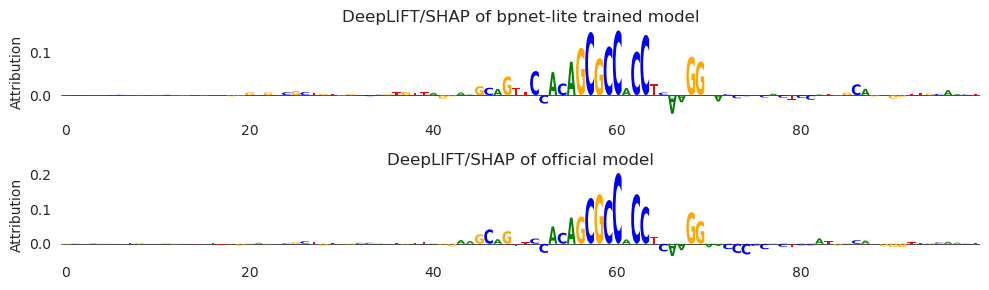

In [15]:
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 3))
plt.subplot(211)
plt.title("DeepLIFT/SHAP of bpnet-lite trained model")
plt.ylabel("Attribution")
plot_logo(X_attr0[0, :, 1000:1100])
plt.grid(False)

plt.subplot(212)
plt.title("DeepLIFT/SHAP of official model")
plt.ylabel("Attribution")
plot_logo(X_attr1[0, :, 1000:1100])
plt.grid(False)



plt.tight_layout()
plt.show()

Looks like they are quite similar -- perhaps even more similar than the predictions, with the two G's to the left of the motif both being highlighted amidst negative attribution characters on either side.

All together, it looks like bpnet-lite produces models using the Python API whose performance is comparable with the official models and attributions/predictions quite similar.